In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv

In [25]:
import requests
import yfinance as yf
import datetime
import pandas_datareader.data as web
#from yahoofinancials import YahooFinancials

In [26]:
import time
import requests
import io

In [27]:
def market_grabber(year_range,regions,mode = "combine",clean_thresh = 0.6 , fill_na = 'bfill'):
    
    ##defining all possible markets can be edited
    tickers_dic = {
    "us_canada":['^GSPC', '^DJI', '^IXIC', '^RUT','^GSPTSE'],
    "latin": ['^BVSP', '^MXX',],
    "east_asia" : ['^N225', '^HSI', '000001.SS', '399001.SZ', '^TWII', '^KS11'],
    "ASEAN_Oceania" : ['^AXJO',  '^NZ50'],
    "south_west_aisa" : ['^BSESN', '^TA125.TA'],
    "Europe" : ['^GDAXI', '^STOXX50E','^N100', '^BFX', '^FCHI','^AEX','^BFX', "^IBEX", "^OMX", "^OMXH25"],
    
    }
    #############################################
    from datetime import datetime

    now = str(datetime.today().strftime('%Y-%m-%d'))
    current_year = int(datetime.today().strftime('%Y'))
    
    area_list = regions
    year_list = [(str(year)+"-01-01",str(year)+"-12-31") for year in year_range]
    
#     year_list = [(str(year)+"-01-01",str(year)+"-12-31" if year_range[-1] != current_year else now) for year in year_range]

    
    area_output ={} #will be filled with the region that you mentioned on region_list
    

    
    for area in area_list: #Loop over the regions only those that exist in region_list
        here = str(year_range[0])+"-01-01"
        there = (str(year_range[-1])+"-12-31"  if year_range[-1] != current_year else now)
        grabbed_data = web.get_data_yahoo(tickers_dic[area],
        start = here,
        end =   there)
        

    
        temp_adj_yearly = []
        for period in year_list:
            dates = pd.date_range(start = period[0], end = period[1])
            df_year = pd.DataFrame(grabbed_data,index=dates)
            
            adj_close = df_year["Adj Close"]
            
            if mode == "dict":
                adj_close = adj_close[adj_close.notnull().mean(axis=1)>=clean_thresh]
                adj_close = adj_close.fillna(method=fill_na,axis = 0)

            

            
            temp_adj_yearly.append(adj_close)
    
        area_output[area]=temp_adj_yearly # adding a key for the correspond region
    
    
    
    
    if mode == "dict":
        return area_output
    ########################################## End of grabbing zone
    
    
    if mode =="combine":
        #COMBINING ZONE : 
        data = area_output

        region_list = []
        for region in regions:

            years_list = []
            for index,year in enumerate(year_range):
                years_list.append(data[region][index])


            years_together = pd.concat(years_list,axis=0)
            region_list.append(years_together)


        combined = pd.concat(region_list,axis=1)  
        
        
        return combined[combined.notnull().mean(axis=1)>=clean_thresh].fillna(method=fill_na,axis = 0)
    
    return -1 #wrong mode or unknown error

In [28]:
all_regions_concated = market_grabber(year_range=[2016,2017,2018,2019,2020],regions=["Europe","us_canada", "latin", "east_asia","ASEAN_Oceania","south_west_aisa" ])

In [29]:
def smooth_with_fuzzy(input_dataframe): #dataframe
    
    smooth_data_frame = input_dataframe.copy()
    
    import cv2 as cv # importing dependency
    kernel = cv.ft.createKernel(cv.ft.LINEAR, 3, 1)

    smooth_with_fuzzy = [] 
    
    for col in smooth_data_frame:
        data_in_col = smooth_data_frame[col] # data read from each column
        series_index = data_in_col.index #will use later 
        
        to_numpy = data_in_col.values
        one_d_numpy = to_numpy.flatten() #to make sure it is one-dimentional

        
        data_TC = cv.ft.FT02D_process(one_d_numpy, kernel).flatten() #fuzzy smoothing
        data_TC[-1] = one_d_numpy[-1]


        # print("input ",one_d_numpy)
        # break
        # print("index ",len(series_index))
        # print("TC ",len(data_TC))

        to_series = pd.Series(data_TC,index=series_index) # to be converted to panda series with similar index
        smooth_data_frame[col] = to_series #replace smooth series
        
    return smooth_data_frame
        
        

        
        

        
        
        

In [30]:
all_regions_TC = smooth_with_fuzzy(all_regions_concated)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-31-cc7069be5da5>:7: RuntimeWarning:

More tha

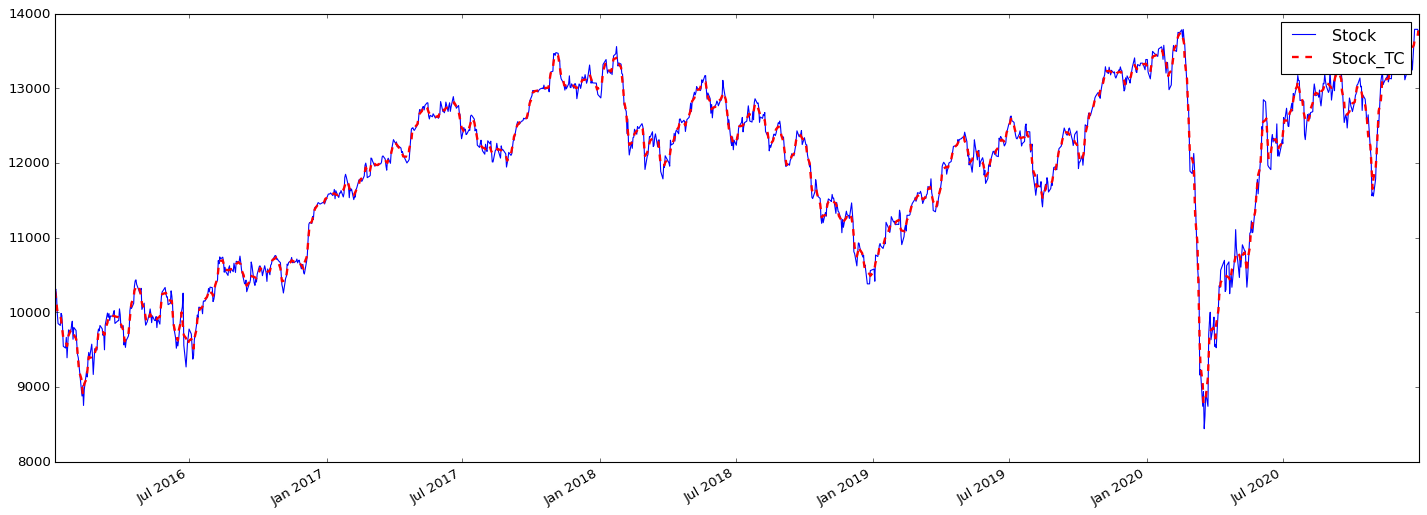

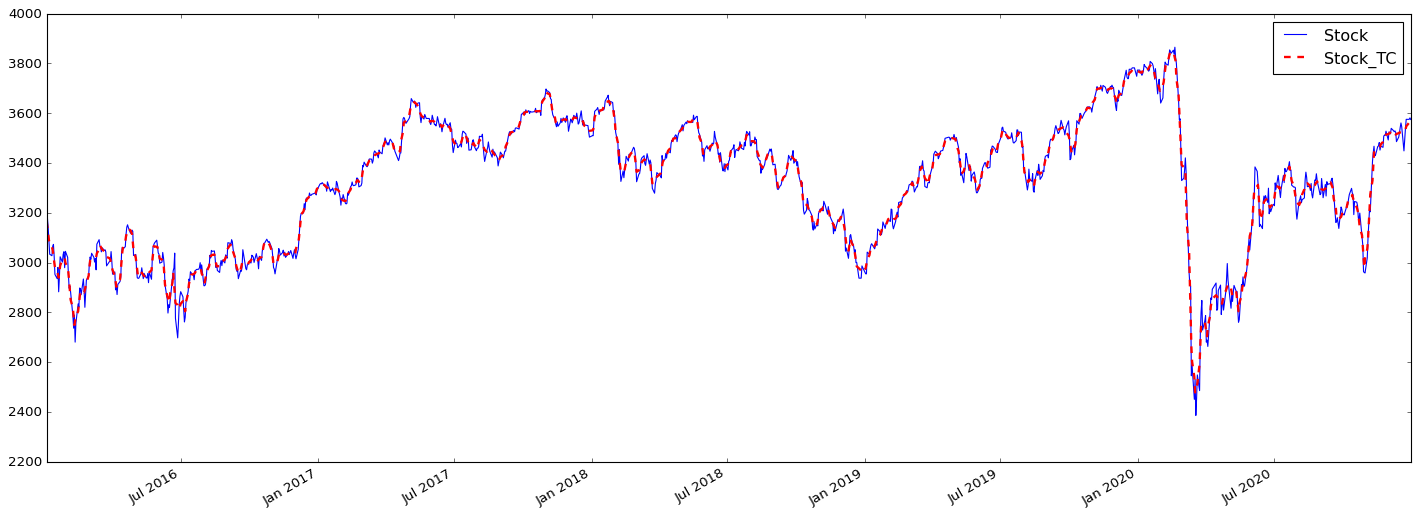

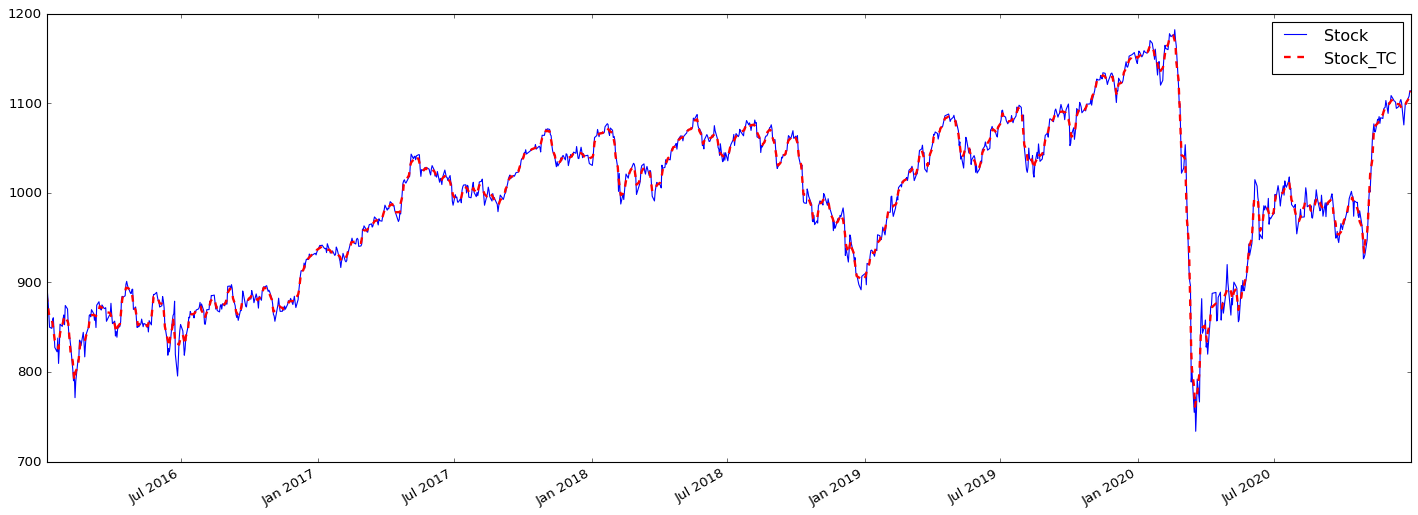

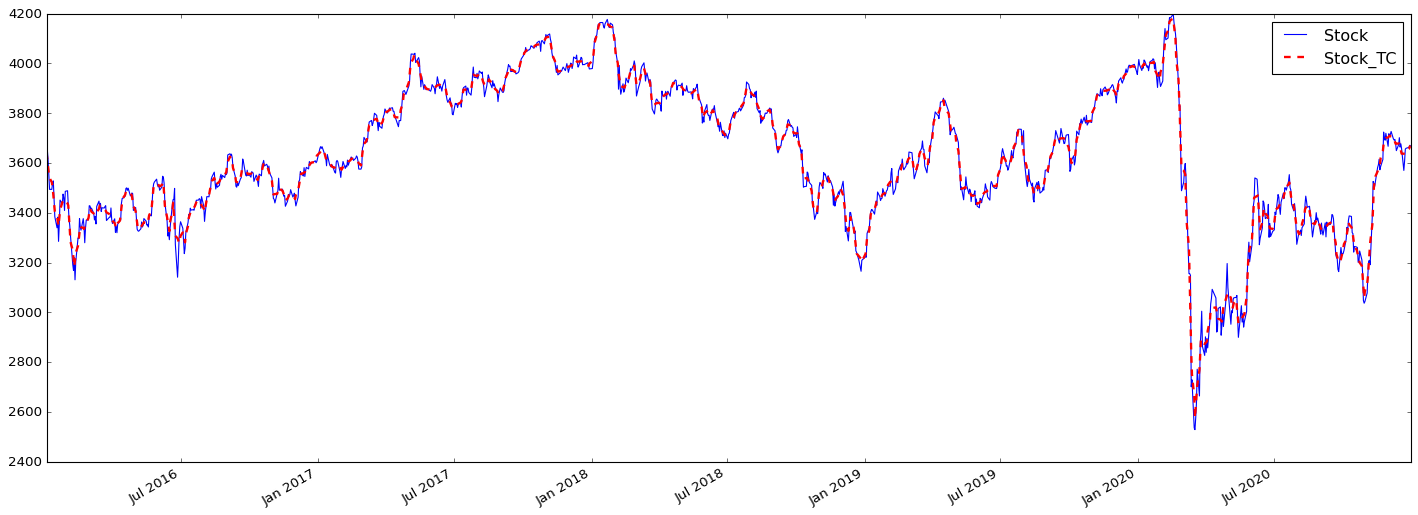

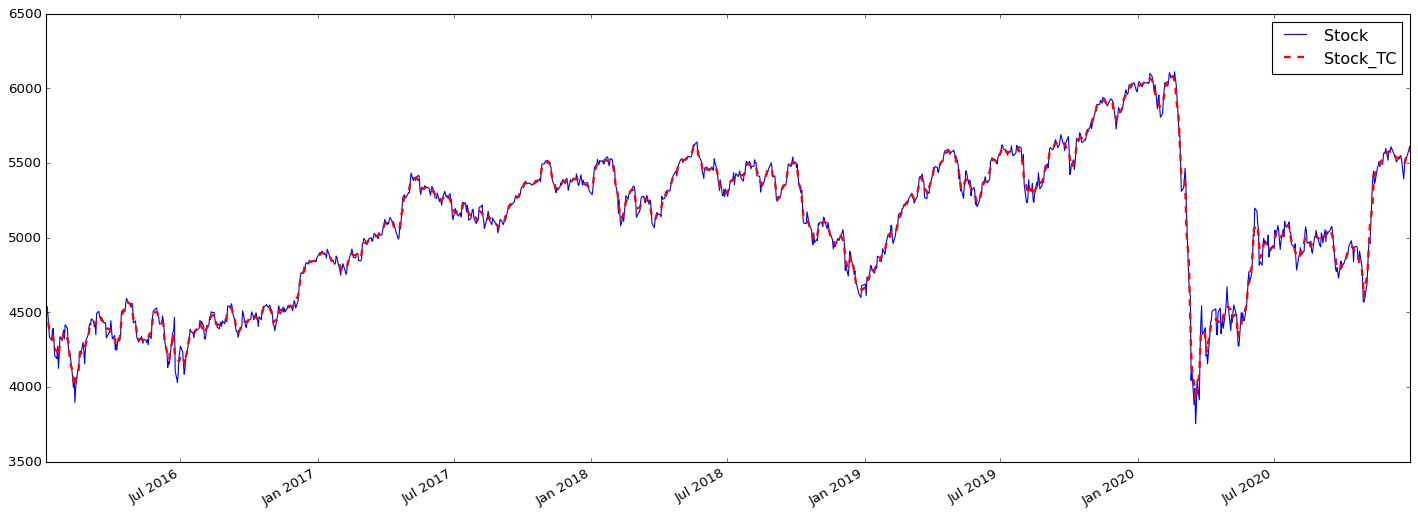

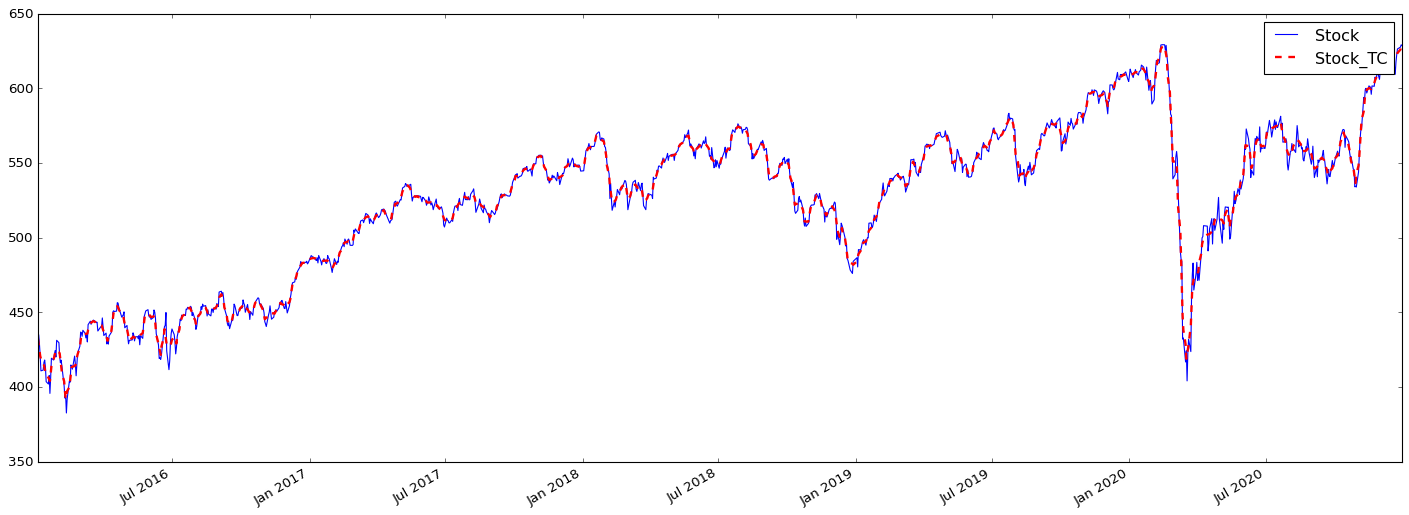

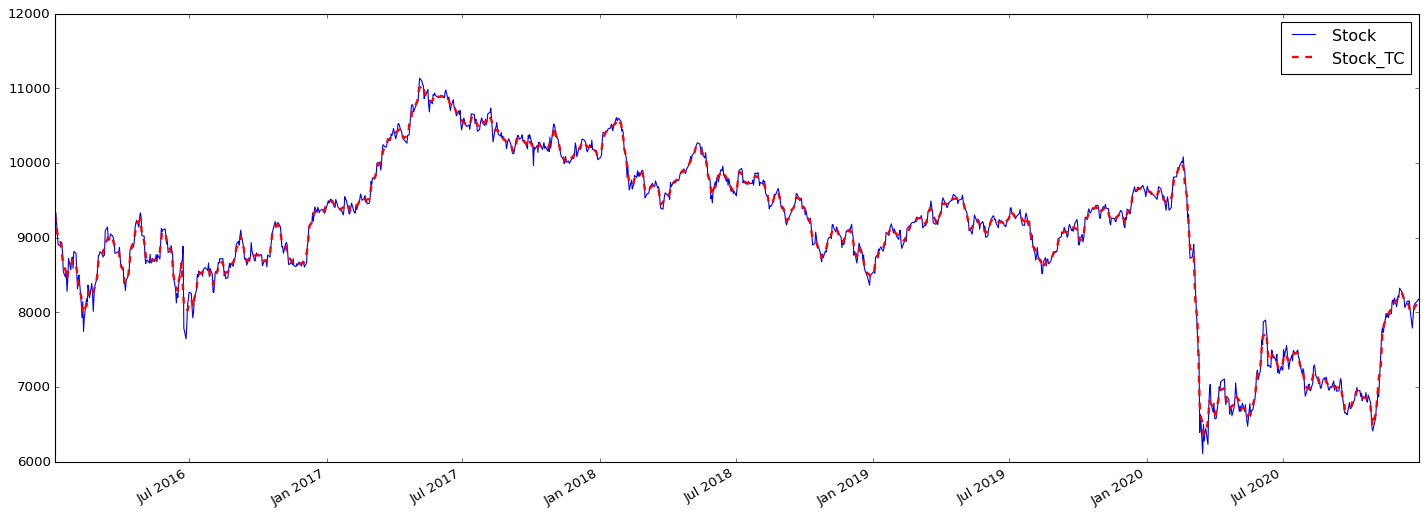

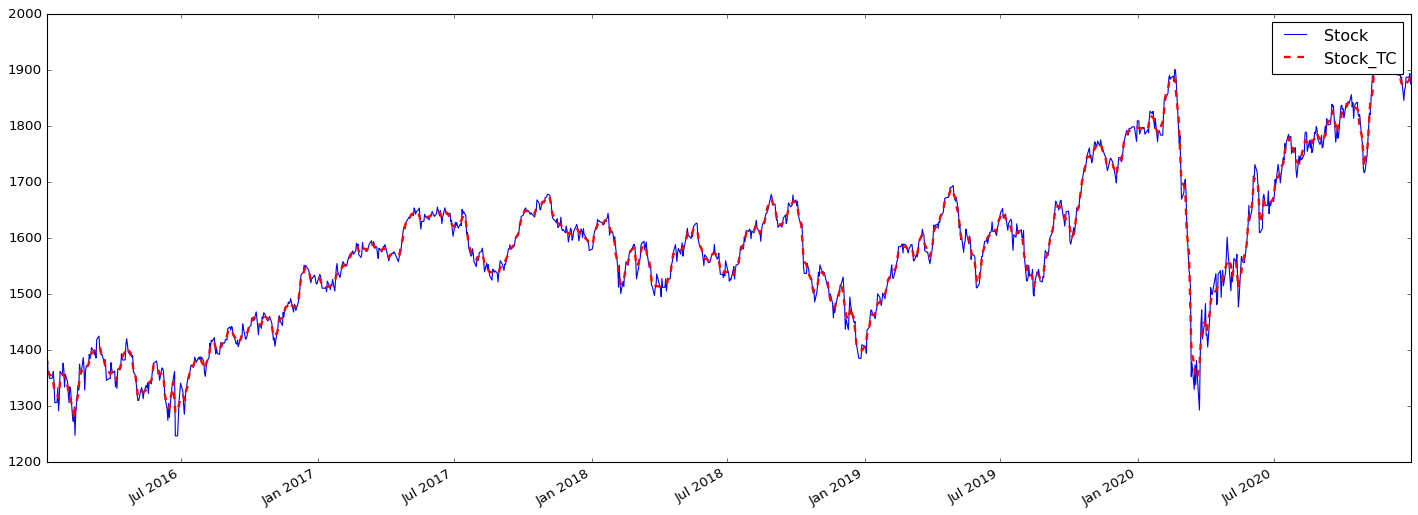

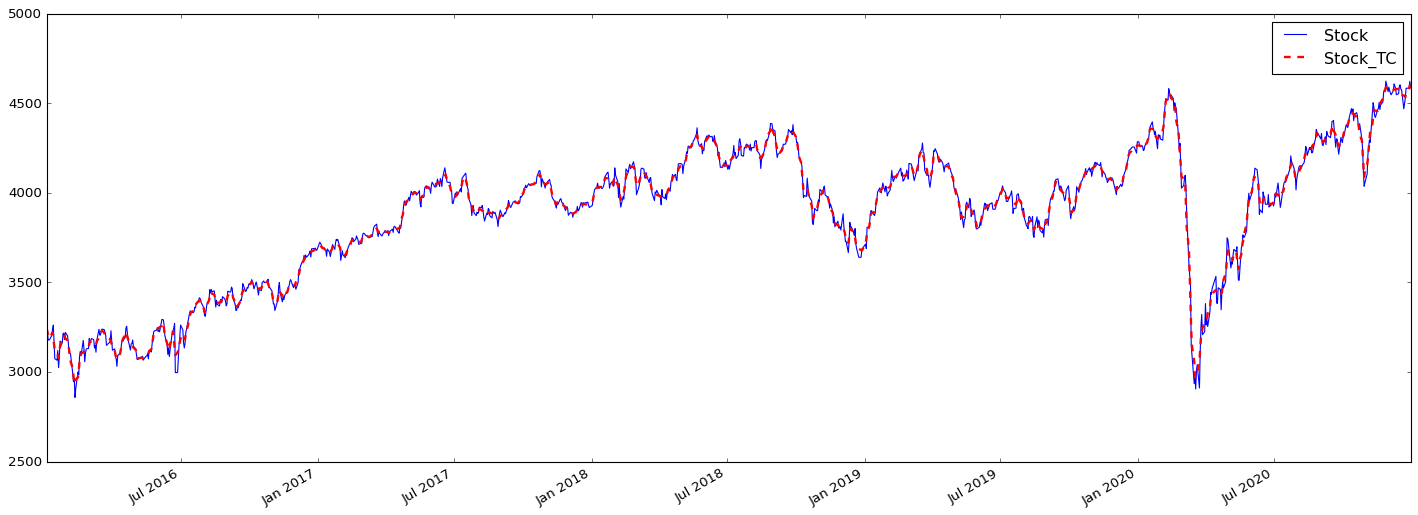

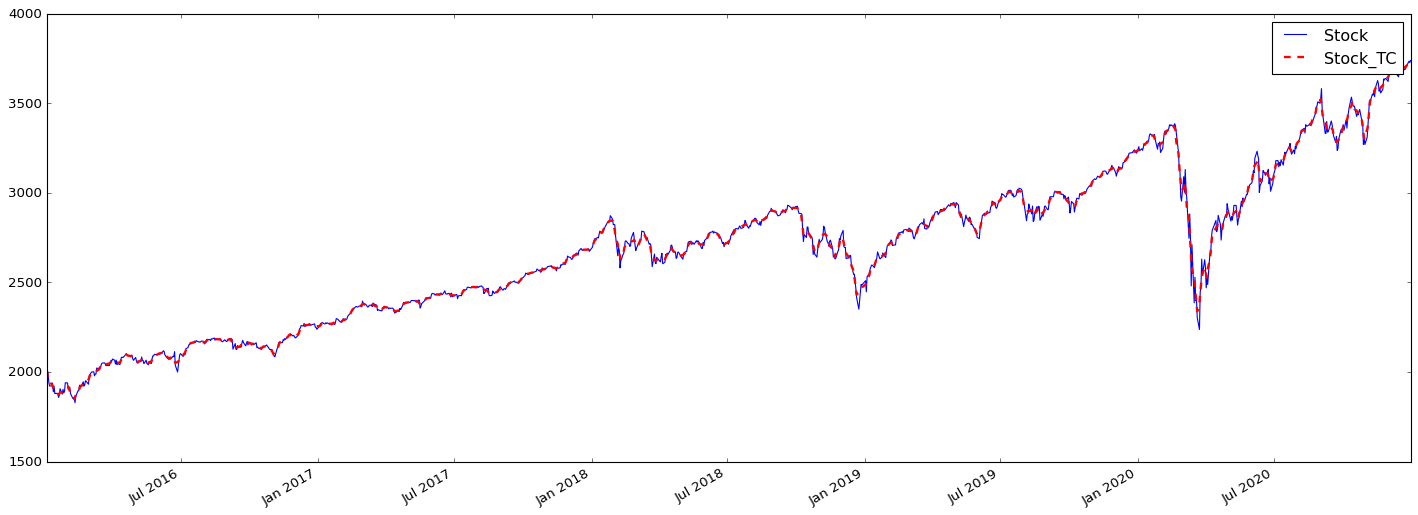

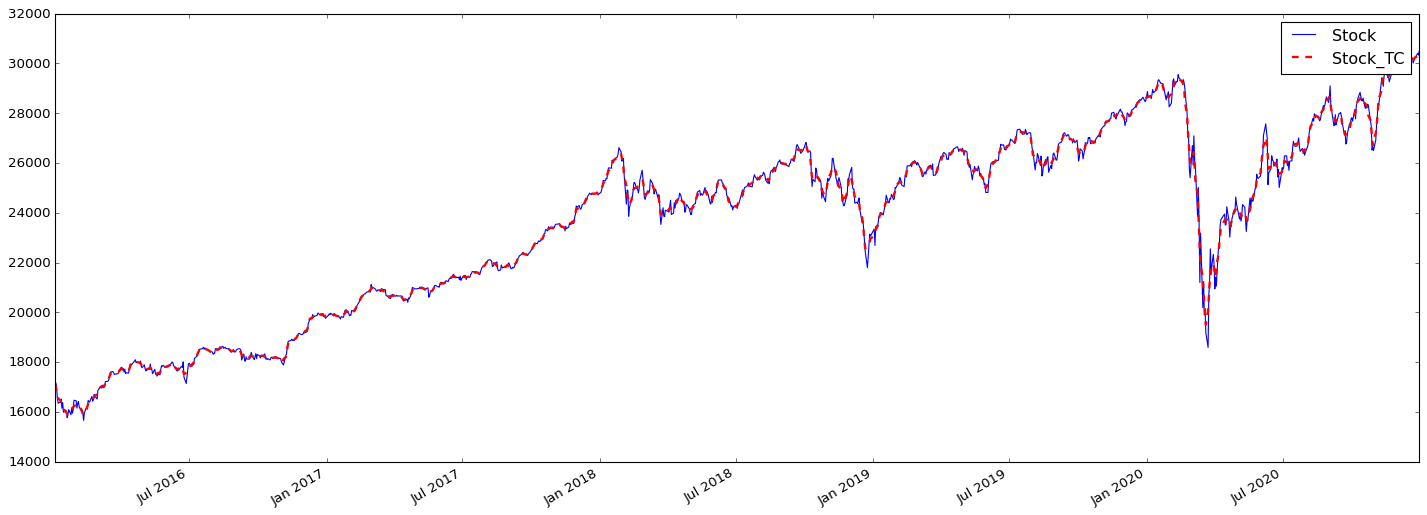

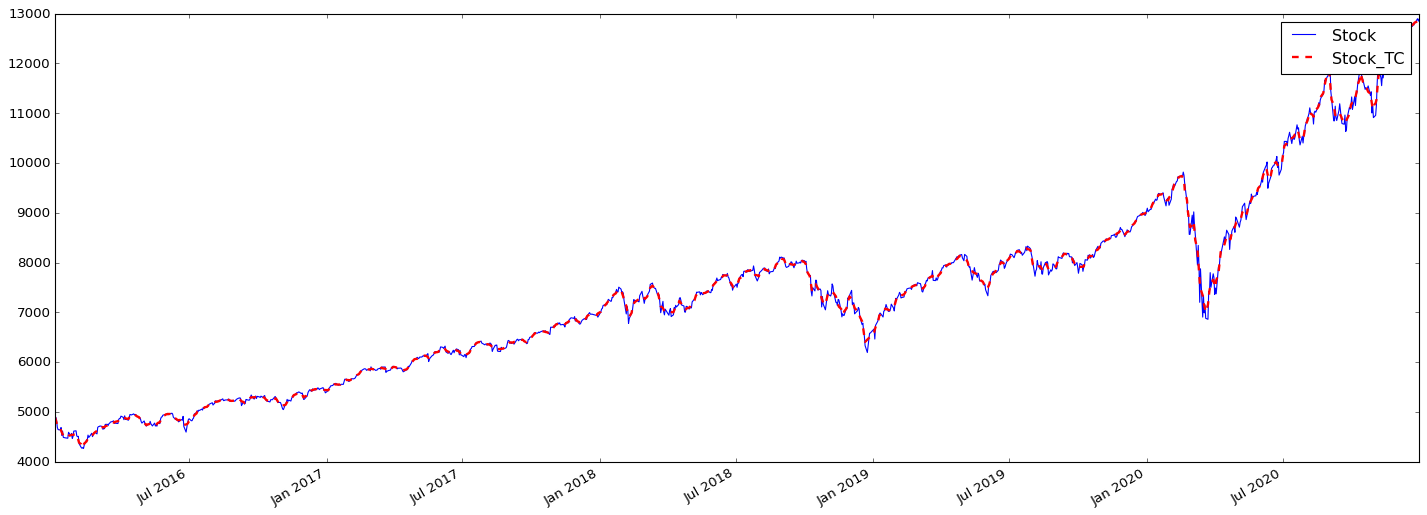

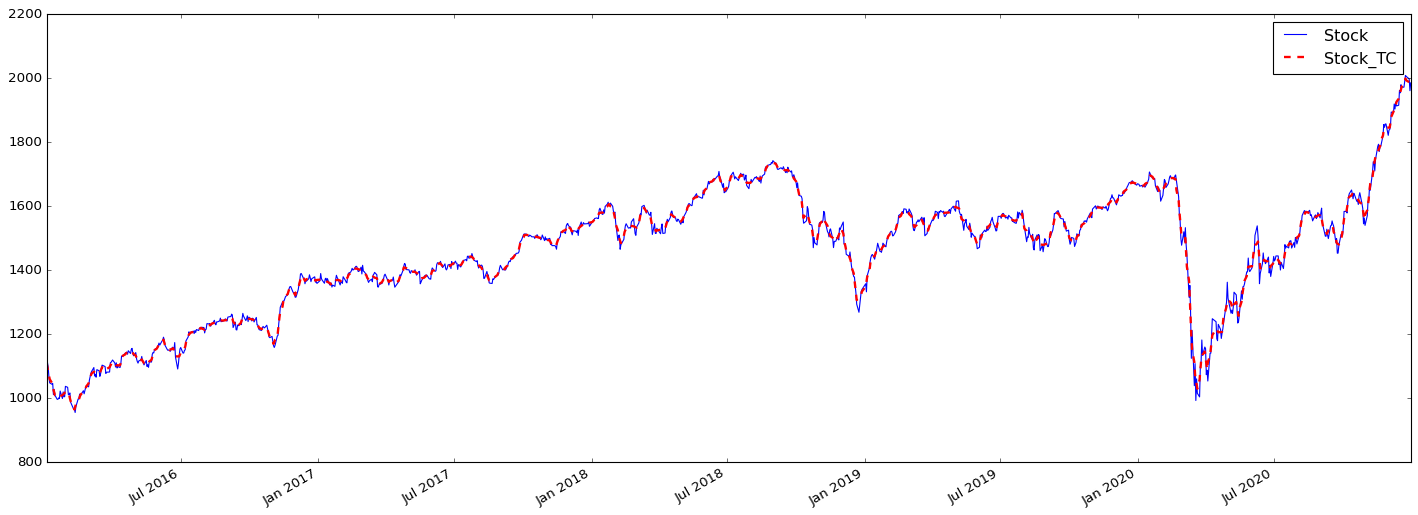

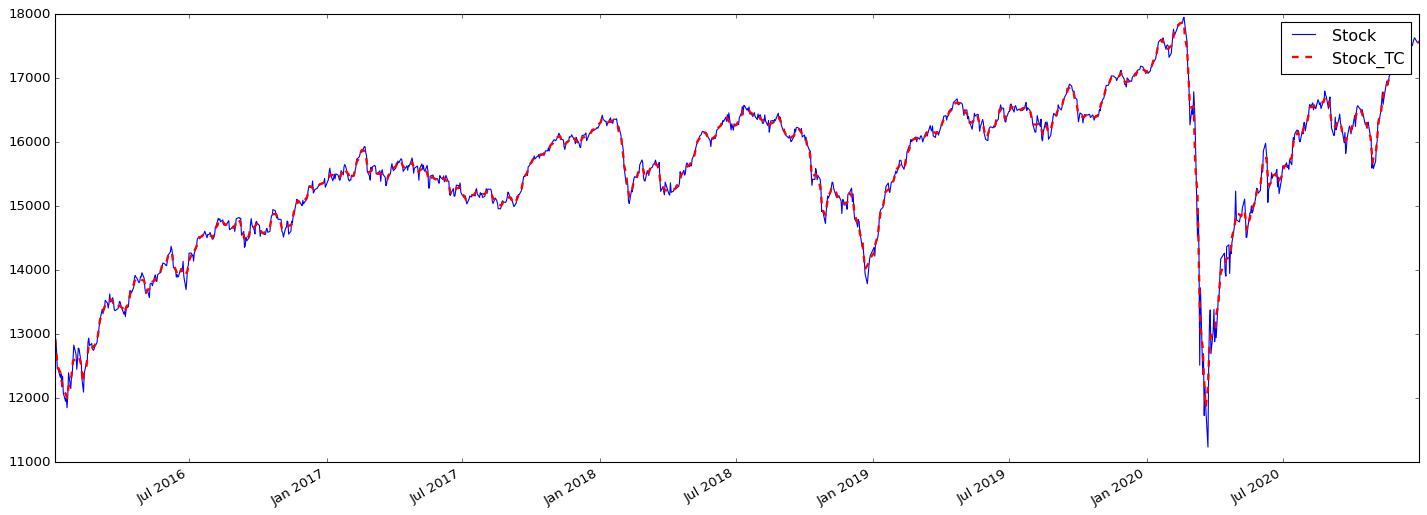

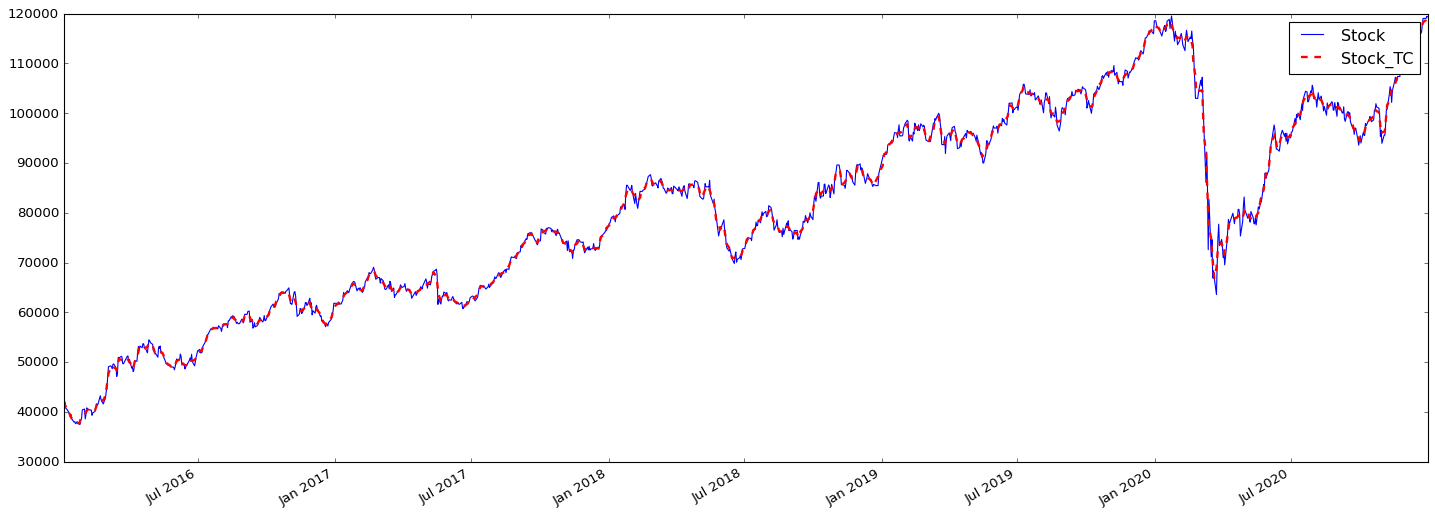

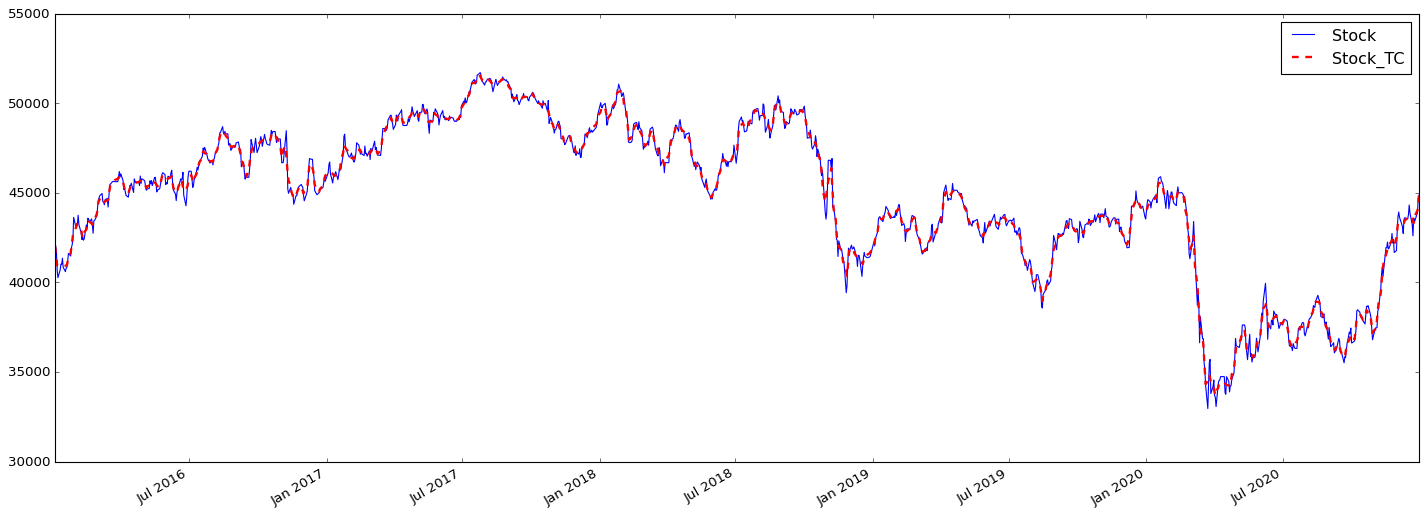

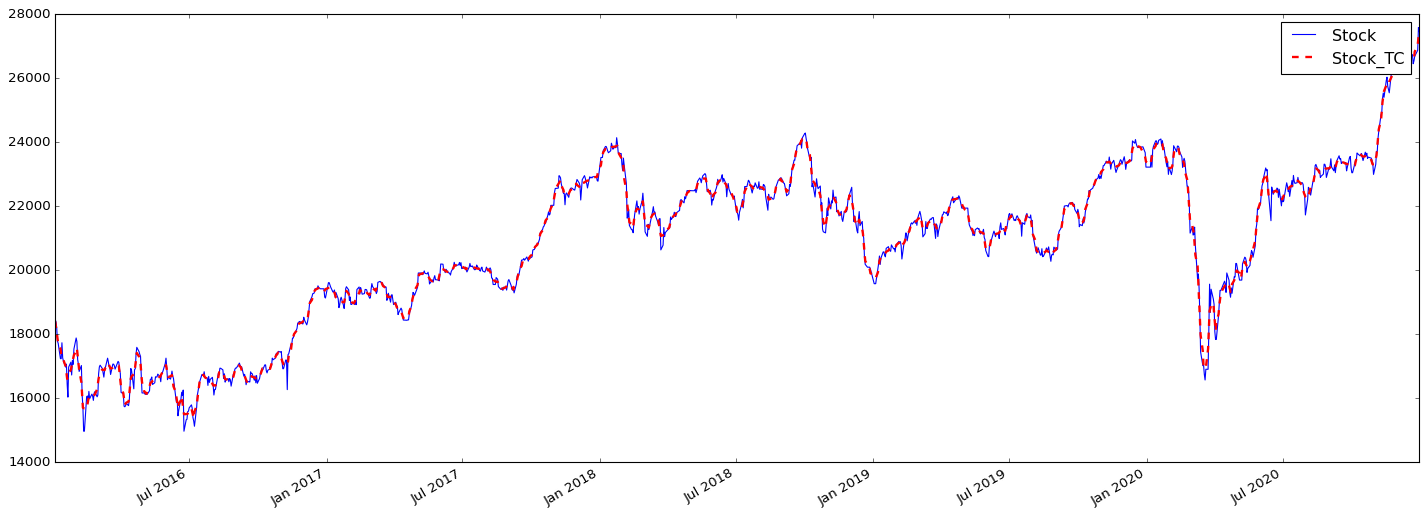

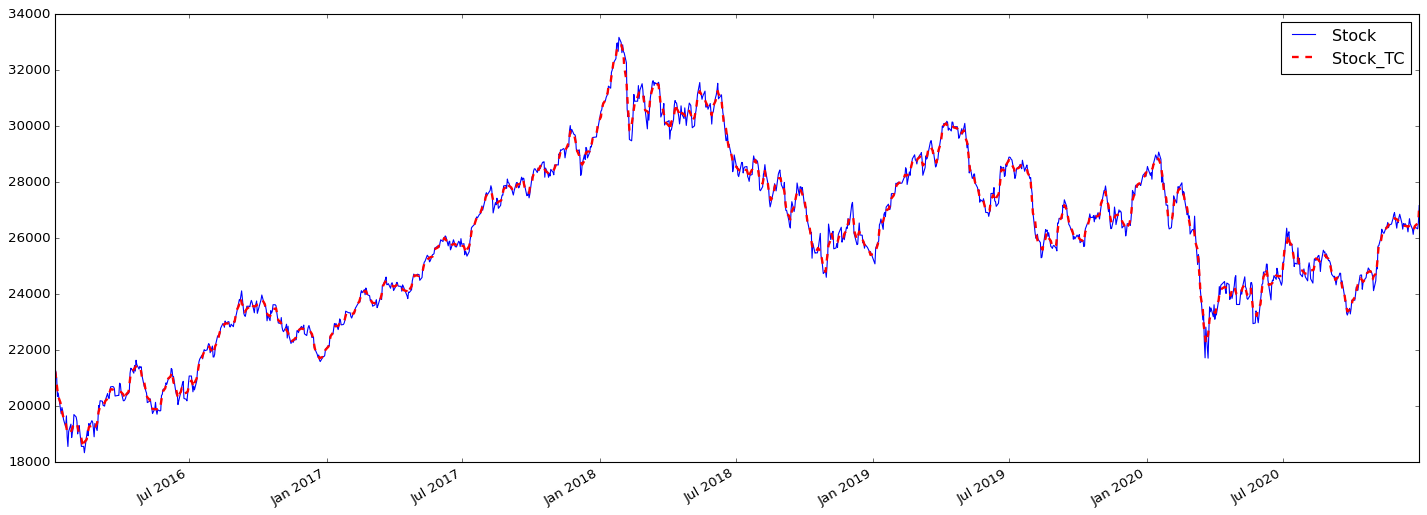

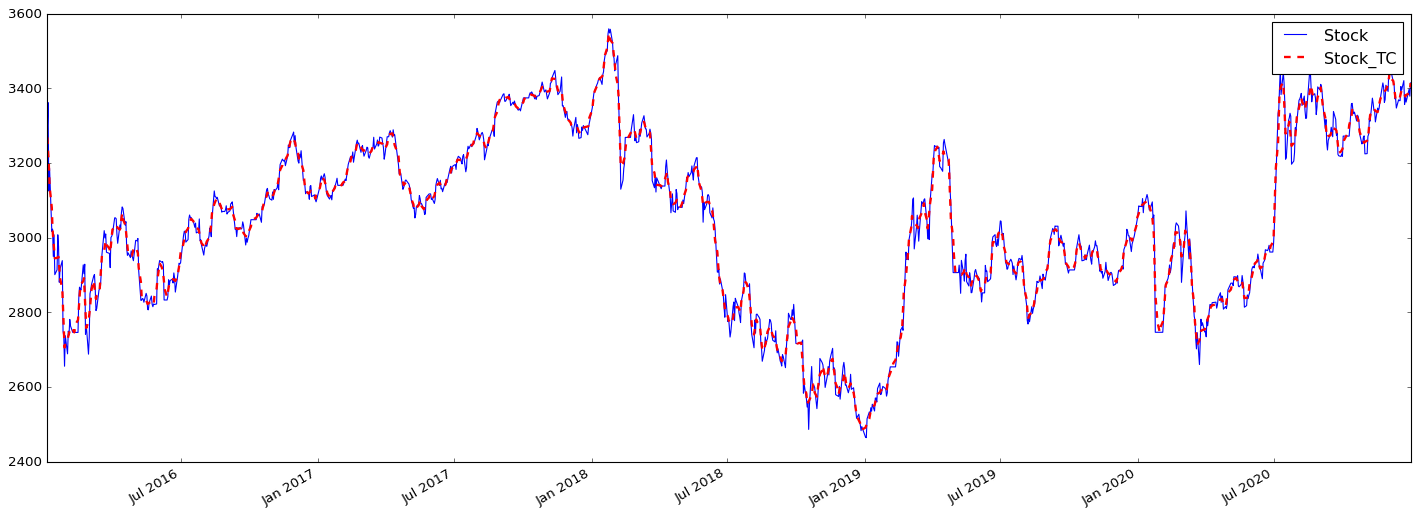

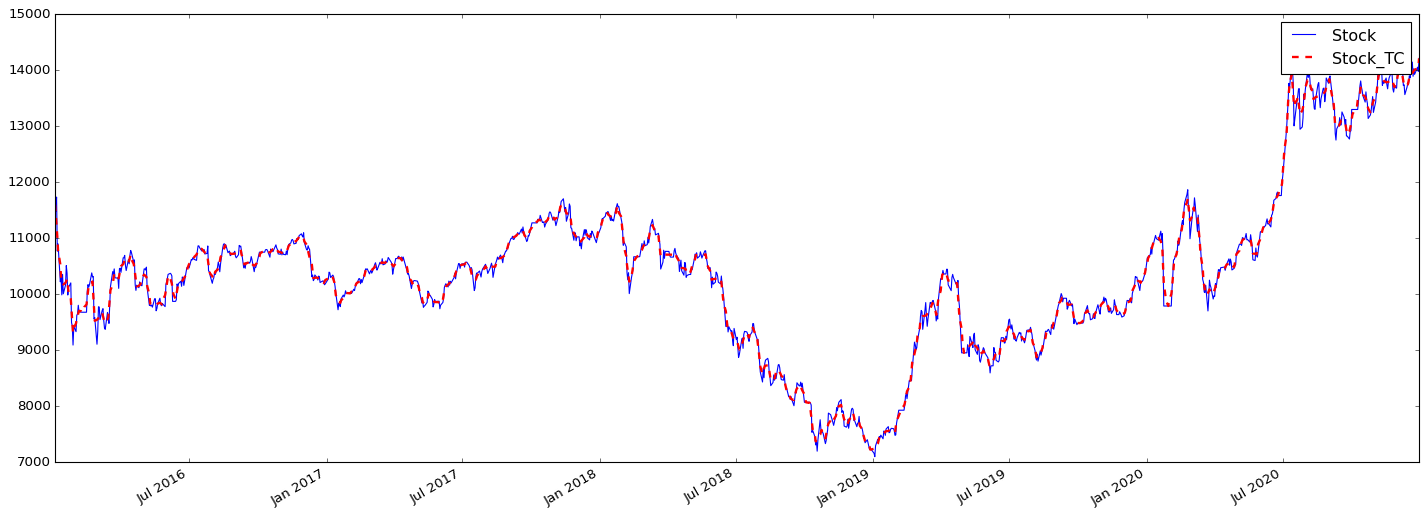

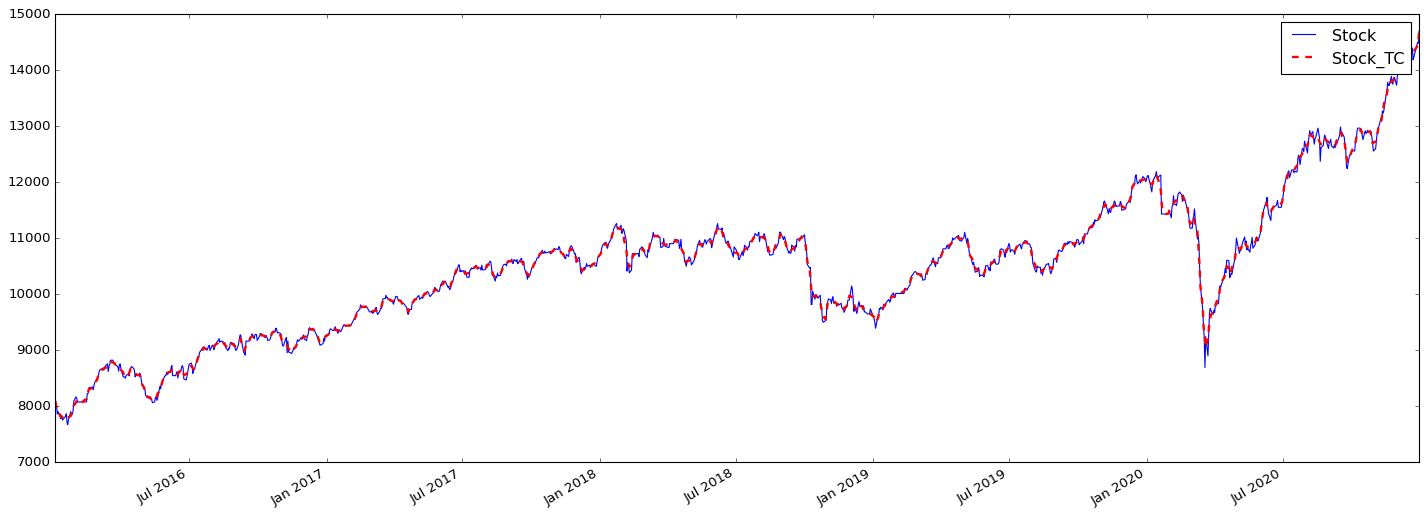

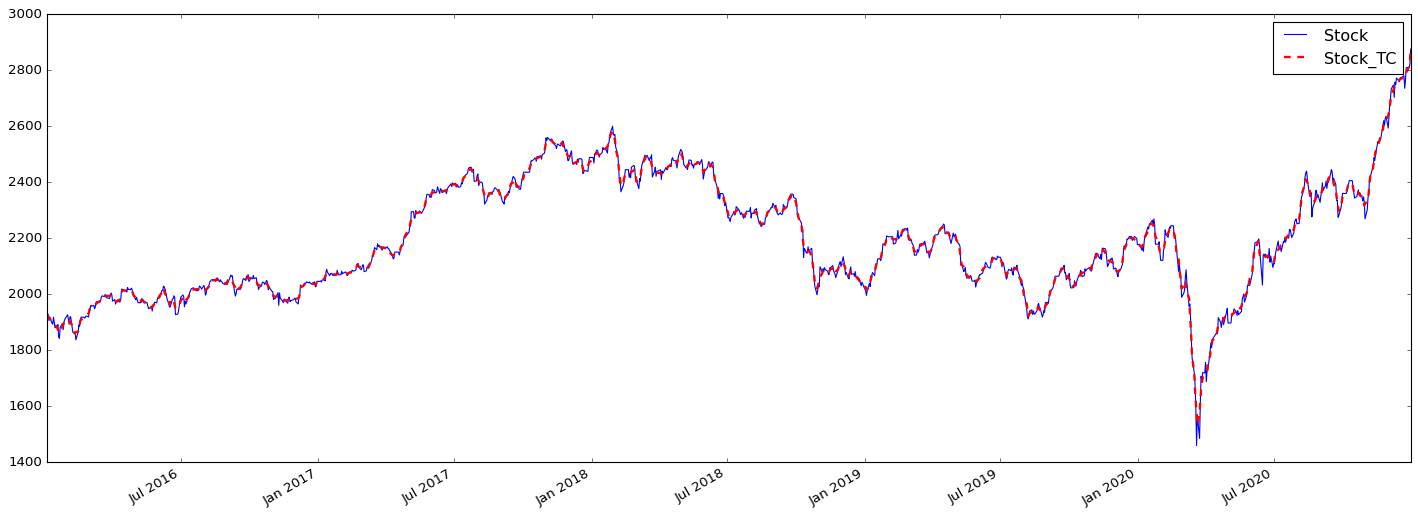

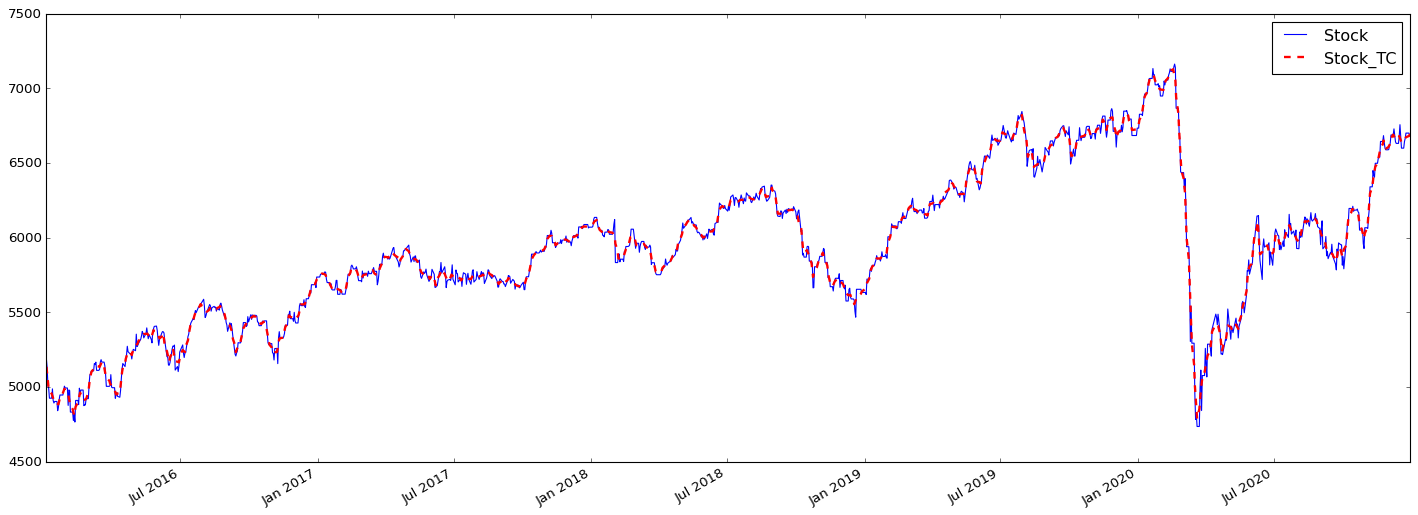

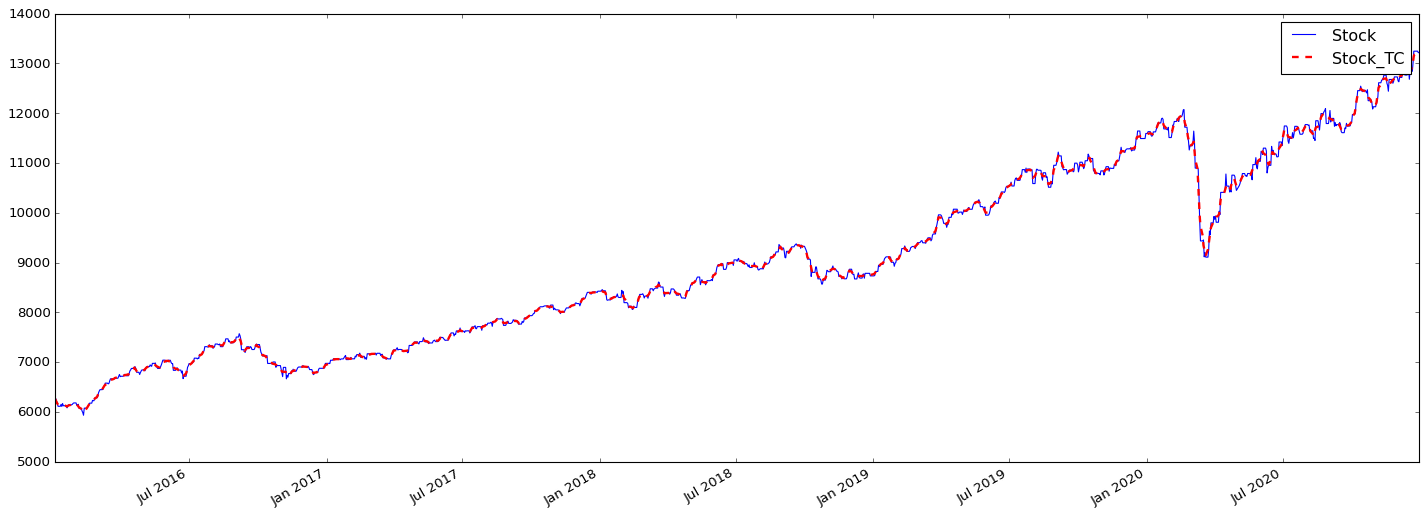

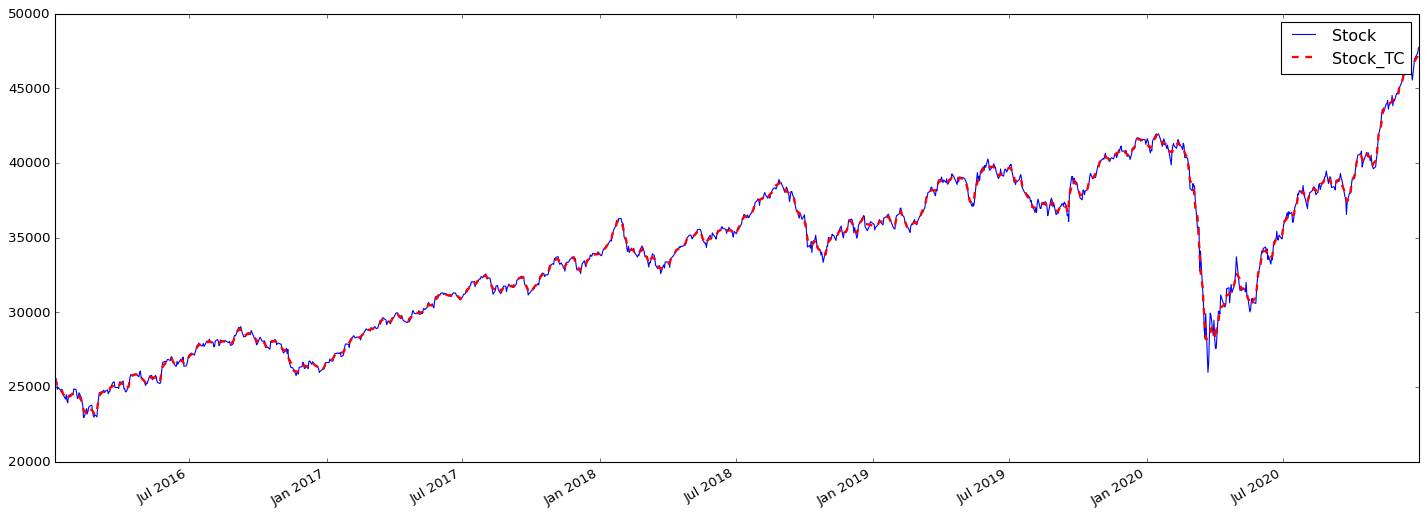

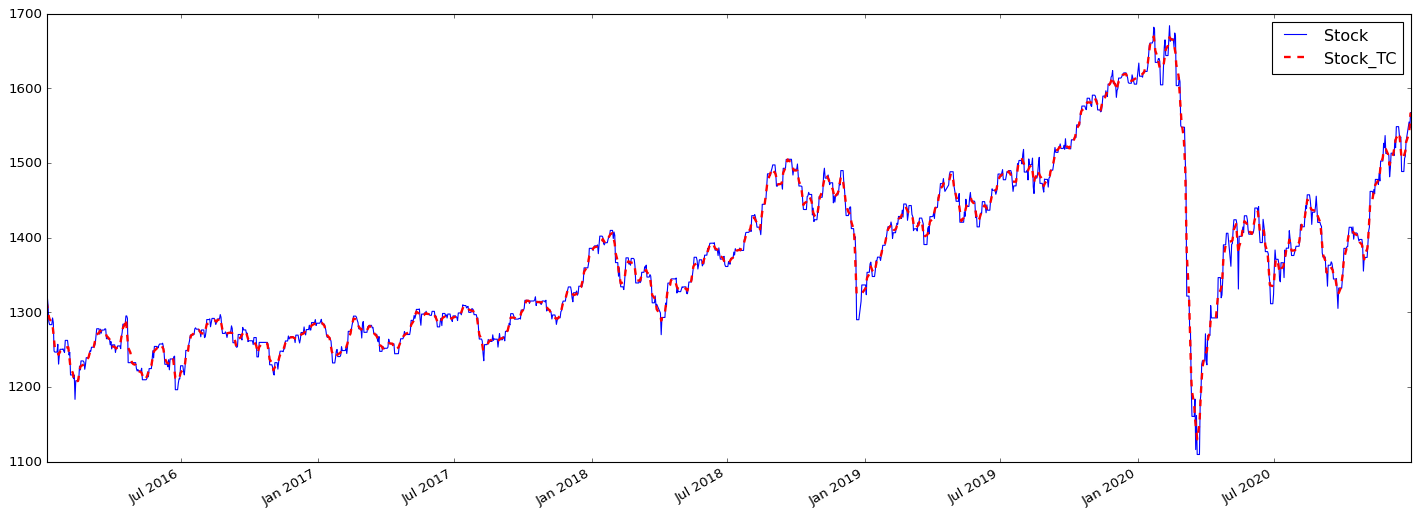

In [31]:
for counter in range(26):
  ts2 =all_regions_concated.iloc[:, counter]
  ts1 =all_regions_TC.iloc[:, counter]


  plt.style.use('classic')
  plt.figure(num=None, figsize=(22, 8), dpi=80, facecolor='w', edgecolor='k')

  ax = plt.gca()
  plt.legend (loc='upper left')

  ts2.plot(kind='line', ax=ax, linewidth=1.0, label='Stock')
  ts1.plot(kind='line',linestyle='dashed', color='red',ax=ax, linewidth=2.1, label='Stock_TC')
  plt.legend (loc='lower right');
  #line, = ax.plot([1, 2, 3])
  #line.set_label('Label via method')
  ax.legend()

In [32]:
all_regions_TC_return = all_regions_TC.pct_change(1).dropna().add_prefix("Return_")

In [33]:
all_regions_TC_return_lag = all_regions_TC_return.shift(1).dropna().add_prefix("lag_")

In [34]:
final_df = pd.concat([all_regions_TC_return.iloc[1:],all_regions_TC_return_lag],axis=1)

In [35]:
final_df

Symbols,Return_^GDAXI,Return_^STOXX50E,Return_^N100,Return_^BFX,Return_^FCHI,Return_^AEX,Return_^IBEX,Return_^OMX,Return_^OMXH25,Return_^GSPC,...,lag_Return_^N225,lag_Return_^HSI,lag_Return_000001.SS,lag_Return_399001.SZ,lag_Return_^TWII,lag_Return_^KS11,lag_Return_^AXJO,lag_Return_^NZ50,lag_Return_^BSESN,lag_Return_^TA125.TA
2016-01-06,-0.008448,-0.008013,-0.007606,-0.007768,-0.008220,-0.008906,-0.008427,-0.006801,-0.005561,-0.009265,...,-0.009600,-0.010581,-0.010795,-0.016361,-0.007043,-0.001727,-0.009543,-0.005077,-0.006537,-0.004948
2016-01-07,-0.008520,-0.008078,-0.007664,-0.007829,-0.008288,-0.008986,-0.008499,-0.006848,-0.005592,-0.009352,...,-0.009694,-0.010694,-0.010913,-0.016633,-0.007093,-0.001730,-0.009635,-0.005103,-0.006580,-0.004973
2016-01-08,-0.003805,-0.004228,-0.004444,-0.004852,-0.004177,-0.004893,-0.006241,-0.001570,0.003320,-0.005805,...,-0.009788,-0.010810,-0.011034,-0.016915,-0.007144,-0.001733,-0.009729,-0.005129,-0.006623,-0.004998
2016-01-11,-0.003819,-0.004246,-0.004464,-0.004876,-0.004194,-0.004917,-0.006281,-0.001572,0.003309,-0.005839,...,-0.008731,-0.010621,-0.018310,-0.022487,-0.004777,-0.002168,-0.003284,-0.001924,-0.003738,-0.002965
2016-01-12,-0.003834,-0.004264,-0.004484,-0.004900,-0.004212,-0.004941,-0.006320,-0.001575,0.003298,-0.005874,...,-0.008808,-0.010735,-0.018652,-0.023004,-0.004800,-0.002172,-0.003295,-0.001928,-0.003752,-0.002974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.001399,0.000954,0.000281,-0.000036,0.000394,0.000512,0.000856,-0.000831,-0.000924,-0.000706,...,-0.001629,-0.001941,-0.001691,0.001527,-0.000173,0.000369,0.001294,0.008236,-0.000194,0.002198
2020-12-24,0.004470,0.004301,0.004547,0.002720,0.005394,0.003738,0.005514,0.002752,0.004736,0.002801,...,-0.001632,-0.001945,-0.001694,0.001524,-0.000173,0.000369,0.001293,0.008169,-0.000194,0.002193
2020-12-28,0.004450,0.004283,0.004526,0.002712,0.005365,0.003724,0.005484,0.002745,0.004713,0.002793,...,0.008165,0.004198,0.001201,0.001424,0.005423,0.006865,0.001228,0.001945,0.007424,0.007934
2020-12-29,0.004431,0.004265,0.004506,0.002705,0.005337,0.003710,0.005454,0.002737,0.004691,0.002785,...,0.008099,0.004180,0.001200,0.001422,0.005394,0.006818,0.001226,0.001941,0.007369,0.007872


In [36]:
final_df_TC = smooth_with_fuzzy(final_df)
#here I am testing if I can apply fuzzy smoother again after calculating the return

In [37]:
final_df_TC

Symbols,Return_^GDAXI,Return_^STOXX50E,Return_^N100,Return_^BFX,Return_^FCHI,Return_^AEX,Return_^IBEX,Return_^OMX,Return_^OMXH25,Return_^GSPC,...,lag_Return_^N225,lag_Return_^HSI,lag_Return_000001.SS,lag_Return_399001.SZ,lag_Return_^TWII,lag_Return_^KS11,lag_Return_^AXJO,lag_Return_^NZ50,lag_Return_^BSESN,lag_Return_^TA125.TA
2016-01-06,-0.007698,-0.007404,-0.007098,-0.007302,-0.007568,-0.008264,-0.008087,-0.005945,-0.004091,-0.008717,...,-0.009663,-0.010657,-0.010874,-0.016544,-0.007077,-0.001729,-0.009605,-0.005095,-0.006566,-0.004964
2016-01-07,-0.006753,-0.006616,-0.006449,-0.006773,-0.006721,-0.007332,-0.007712,-0.004890,-0.002467,-0.007864,...,-0.009478,-0.010679,-0.012591,-0.017973,-0.006575,-0.001827,-0.008212,-0.004393,-0.005944,-0.004524
2016-01-08,-0.005808,-0.005828,-0.005799,-0.006243,-0.005874,-0.006400,-0.007337,-0.003835,-0.000842,-0.007010,...,-0.009292,-0.010700,-0.014308,-0.019402,-0.006072,-0.001926,-0.006820,-0.003692,-0.005323,-0.004084
2016-01-11,-0.004864,-0.005040,-0.005150,-0.005714,-0.005027,-0.005468,-0.006962,-0.002780,0.000782,-0.006157,...,-0.009107,-0.010722,-0.016024,-0.020831,-0.005570,-0.002024,-0.005427,-0.002991,-0.004701,-0.003644
2016-01-12,-0.005748,-0.005666,-0.005676,-0.006682,-0.005633,-0.005444,-0.007801,-0.003855,-0.002279,-0.005783,...,-0.007942,-0.009516,-0.014677,-0.017303,-0.004349,-0.002081,-0.004648,-0.002206,-0.004381,-0.004535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.002404,0.001926,0.001681,0.000620,0.001947,0.001652,0.001959,0.000037,0.000776,0.000770,...,0.000907,0.000020,-0.000105,0.002130,0.001545,0.001847,0.000532,0.005166,0.001680,0.001308
2020-12-24,0.002838,0.002642,0.002778,0.001382,0.003223,0.002339,0.003233,0.000709,0.002013,0.001572,...,0.002889,0.001082,0.000066,0.001794,0.002545,0.003263,0.000891,0.004595,0.003270,0.003650
2020-12-28,0.003272,0.003358,0.003875,0.002144,0.004500,0.003026,0.004507,0.001380,0.003250,0.002375,...,0.004870,0.002143,0.000236,0.001457,0.003545,0.004679,0.001249,0.004025,0.004860,0.005993
2020-12-29,0.001982,0.002554,0.003730,0.001806,0.004158,0.002575,0.003904,-0.000099,0.002062,0.002454,...,0.005932,0.002818,0.000557,0.001445,0.004155,0.005382,0.001241,0.003330,0.005684,0.006606


In [38]:
final_df_tr=final_df.transpose()

In [39]:
final_df_tc_tr=final_df_TC.transpose()

In [40]:
from scipy.spatial.distance import pdist, squareform

def vil_dis(X, Y):
    E_X=np.mean(X)
    E_Y=np.mean(Y)
    n = len(X)
    sumation = 0
    
    for i,j in zip( X, Y ): 
        up = abs((i - E_X) - (j - E_Y))
        down = abs(i - E_X) + abs(j - E_Y)
        sumation = sumation + (up/down)
       
    return abs((sumation)/n)

In [41]:
final_distance_array = pdist(final_df, vil_dis)
#dis_novak_final_df_tr.shape
final_distance_matrix = squareform(final_distance_array)

final_smilarity_matrix = 1- final_distance_matrix
print(final_smilarity_matrix)

[[1.         0.96318643 0.42473769 ... 0.45495514 0.45495351 0.35404241]
 [0.96318643 1.         0.42754668 ... 0.4567422  0.45690098 0.35508379]
 [0.42473769 0.42754668 1.         ... 0.32985986 0.3292152  0.27135553]
 ...
 [0.45495514 0.4567422  0.32985986 ... 1.         0.99504324 0.64876639]
 [0.45495351 0.45690098 0.3292152  ... 0.99504324 1.         0.64701399]
 [0.35404241 0.35508379 0.27135553 ... 0.64876639 0.64701399 1.        ]]


In [42]:
final_TC_distance_array = pdist(final_df_tc_tr, vil_dis)
#dis_novak_final_df_tr.shape
final_TC_distance_matrix = squareform(final_TC_distance_array)

final_TC_smilarity_matrix = 1- final_TC_distance_matrix
print(final_TC_smilarity_matrix)

[[1.         0.69932559 0.65203547 ... 0.34329096 0.36428868 0.41190416]
 [0.69932559 1.         0.76013619 ... 0.33707244 0.37514834 0.42050317]
 [0.65203547 0.76013619 1.         ... 0.3592058  0.38379066 0.44005868]
 ...
 [0.34329096 0.33707244 0.3592058  ... 1.         0.34773286 0.38461905]
 [0.36428868 0.37514834 0.38379066 ... 0.34773286 1.         0.37826328]
 [0.41190416 0.42050317 0.44005868 ... 0.38461905 0.37826328 1.        ]]


In [43]:
final_df_tr

,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-18,2016-01-19,...,2020-12-16,2020-12-17,2020-12-18,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-28,2020-12-29,2020-12-30
Symbols,,,,,,,,,,,,,,,,,,,,,
Return_^GDAXI,-0.008448,-0.008520,-0.003805,-0.003819,-0.003834,-0.008518,-0.008592,-0.008666,-0.003662,-0.003676,...,0.003471,0.003459,0.003447,0.001403,0.001401,0.001399,0.004470,0.004450,0.004431,-0.003109
Return_^STOXX50E,-0.008013,-0.008078,-0.004228,-0.004246,-0.004264,-0.007561,-0.007619,-0.007678,-0.004653,-0.004675,...,-0.000087,-0.000088,-0.000087,0.000955,0.000955,0.000954,0.004301,0.004283,0.004265,-0.000713
Return_^N100,-0.007606,-0.007664,-0.004444,-0.004464,-0.004484,-0.007436,-0.007491,-0.007548,-0.003614,-0.003627,...,-0.001256,-0.001257,-0.001259,0.000281,0.000281,0.000281,0.004547,0.004526,0.004506,0.002906
Return_^BFX,-0.007768,-0.007829,-0.004852,-0.004876,-0.004900,-0.009468,-0.009558,-0.009651,-0.005761,-0.005794,...,-0.003708,-0.003722,-0.003736,-0.000036,-0.000036,-0.000036,0.002720,0.002712,0.002705,0.000343
Return_^FCHI,-0.008220,-0.008288,-0.004177,-0.004194,-0.004212,-0.007592,-0.007650,-0.007709,-0.003840,-0.003855,...,-0.002111,-0.002115,-0.002120,0.000394,0.000394,0.000394,0.005394,0.005365,0.005337,0.002546
Return_^AEX,-0.008906,-0.008986,-0.004893,-0.004917,-0.004941,-0.005803,-0.005837,-0.005871,-0.002764,-0.002772,...,0.001359,0.001358,0.001356,0.000513,0.000513,0.000512,0.003738,0.003724,0.003710,0.000655
Return_^IBEX,-0.008427,-0.008499,-0.006241,-0.006281,-0.006320,-0.010198,-0.010303,-0.010410,-0.006868,-0.006916,...,-0.005289,-0.005317,-0.005346,0.000857,0.000856,0.000856,0.005514,0.005484,0.005454,0.001319
Return_^OMX,-0.006801,-0.006848,-0.001570,-0.001572,-0.001575,-0.007165,-0.007217,-0.007269,-0.001963,-0.001967,...,-0.002645,-0.002652,-0.002659,-0.000829,-0.000830,-0.000831,0.002752,0.002745,0.002737,-0.005957
Return_^OMXH25,-0.005561,-0.005592,0.003320,0.003309,0.003298,-0.010528,-0.010641,-0.010755,-0.004426,-0.004445,...,-0.002413,-0.002418,-0.002424,-0.000922,-0.000923,-0.000924,0.004736,0.004713,0.004691,-0.002817


In [ ]:
%pip install cuflinks

In [23]:
import pandas as pd
import numpy as np  
%matplotlib inline  
from plotly import __version__ 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

# Correct datatypes cufflinks does not support CategoryType so we make them strings and rebuild the dataframe. 
# df_flights = pd.DataFrame(data=final_df_tr, index=final_df_tr.index.astype('str'), columns=final_df_tr.columns)
%%opts HeatMap (cmap='BuPu')
%%output size=250
final_df_tr.iplot(kind='heatmap')

ModuleNotFoundError: No module named 'cufflinks'

In [ ]:
import holoviews as hv
hv.extension('bokeh')


In [ ]:
%%opts HeatMap (cmap='BuPu')
%%output size=250
hv.HeatMap(final_smilarity_matrix, label="Heatmap of Flight Density from 1949 to 1961" )

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

sns.set(rc={'figure.facecolor':'white'})


fig, ax = plt.subplots(figsize=(11,7))

# ax = sns.heatmap(final_smilarity_matrix, cmap='OrRd', annot=False, linewidth=0)
ax = sns.heatmap(final_smilarity_matrix, cmap='OrRd',xticklabels=final_df.columns, yticklabels=final_df.columns, annot=False, linewidth=0)

ax.set_title('Fuzzy similarity on global stocks for level and lag', fontsize=12)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(17,11))

ax = sns.heatmap(final_TC_smilarity_matrix, cmap='OrRd',xticklabels=final_df.columns, yticklabels=final_df.columns, annot=False, linewidth=0)
ax.set_title('Fuzzy similarity on global stocks for level and lag', fontsize=12)

plt.show()